# E7. 네이버 영화리뷰 감성분석 도전하기

### Background 

이번 프로젝트는 네이버 영화리뷰에 대한 감성분석(sentiment analysis)이다. 감성분석이란 supervised learning의 일종으로 텍스트에서 글 작성자의 주관적 의견이나 감정 등을 분석하는 것이다. 분석을 통해서 긍정, 부정 혹은 중립의 감정으로 텍스트를 분류한다.    
   
여기서 학습데이터로 주어진 것은 네이버 영화리뷰 15만건이다. 이미 긍정과 부정의 labeling이 되어 있으므로 (긍정-1, 부정-0) supervised learning의 학습니다. 이 데이터를 모델에 학습시키고, 그 모델로 테스트 데이터 5만건에 대해서 영화에 대한 리뷰가 긍정인지 부정인지를 테스트함으로써 모델의 성능을 평가한다. 목표는 정확도 85%이다. 


### Executive Summary 

1. 데이터 전처리      
    1) 데이터 가공     
        * 중복 제거    
        * NaN 결측치 제거    
        * 불용어(Stopwords) 제거    
    2) 토큰화     
    3) word to index 사전 구성     
    4) index to word     
    5) 최대 문장 길이 지정 - 설정값은 95%의 데이터를 수용     
    6) 패딩추가 ('pre' 사용)     

2. validation set 생성: train 60%/ validation 40%       

3. 모델 
    1)LSTM; 2)CNN; 3)CNN/LSTM    
    
4. 성능 향상을 위한 노력   
사전 학습된 Word2Vec를 가져와서 모델에 넣어보고 validation accuracy를 향상 시키기 위해 epoch를 조정해 주었다. 그러나, 큰 성능향상이 없었다. test시 CNN/LSTM Word2Vec를 쓴 모델이 가장 성능이 높았다. accuracy rate은 85%. 

metrics|model1(LSTM)| model1(LSTM) with Word2Vec| model2(CNN)| model2(CNN) with word2Vec| model3(CNN/LSTM)| model3(CNN/LSTM) with word2Vec
---|---|---|---|---|---|---
loss|0.4| 0.37|0.49|0.47|0.36|0.39
accuracy|0.84|0.84|0.81|0.80|0.84|0.85


### Step 0. 필요한 모듈 가져오기

In [11]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
import os
from tensorflow.keras.initializers import Constant

### Step 1. 데이터 준비

In [12]:
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [13]:
print(train_data.shape)
print(test_data.shape)

(150000, 3)
(50000, 3)


### Step 2. 데이터로더 구성

nsmc 데이터셋은 전혀 가공되지 않은 텍스트 파일로 이루어져 있습니다. 이것을 읽어서 imdb.data_loader()와 동일하게 동작하는 자신만의 data_loader를 만들어 보는 것으로 시작합니다. data_loader 안에서는 다음을 수행해야 합니다.

    1. 데이터의 중복 제거
    2. NaN 결측치 제거
    3. 한국어 토크나이저로 토큰화
    4. 불용어(Stopwords) 제거
    5. 사전word_to_index 구성
    6. 텍스트 스트링을 사전 인덱스 스트링으로 변환
    7. X_train, y_train, X_test, y_test, word_to_index 리턴

In [14]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
    
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [15]:
X_train[3]

[8409, 158, 3925, 4, 4, 298, 94, 17, 6, 4, 4, 58, 3479]

In [16]:
# 몇가지 추가해 주기
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3

In [17]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [18]:
print(len(word_to_index.keys()))

10001


In [19]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [20]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [21]:
print(X_train[0])
print(get_decoded_sentence(X_train[0], index_to_word))

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
더 빙 . . 진짜 짜증 나 네요 목소리


### Step 3. 모델구성을 위한 데이터 분석 및 가공

* 데이터셋 내 문장 길이 분포
* 적절한 최대 문장 길이 지정 - 설정값은 95%의 데이터를 수용할 수준으로 해준다. 
* keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가 - 'pre' 사용

In [22]:
# 텍스트데이터 문장길이의 리스트를 생성
total_data_text = list(X_train) + list(X_test)
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 95% 문장 포함  
max_tokens = np.mean(num_tokens) + 2.5 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  48
전체 문장의 0.9548784420929768%가 maxlen 설정값 이내에 포함됩니다. 


In [23]:
# padding = pre
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', 
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', 
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 48)


### Step 4. validation set 구성
* approx. 60% (88,182)- train set    
* approx. 40% (58,000) - validation set

In [24]:
print(len(X_train)*0.4)

58472.8


In [25]:
# validation set 분리
X_val = X_train[:58000]   
y_val = y_train[:58000]

# validation set을 제외한 나머지 
partial_x_train = X_train[58000:]  
partial_y_train = y_train[58000:]

print(partial_x_train.shape)
print(partial_y_train.shape)
print(X_val.shape)
print(y_val.shape)

(88182, 48)
(88182,)
(58000, 48)
(58000,)


### Step 5. 모델 만들고, 훈련 및 평가하기 

model3가 가장 좋은 성능을 보인다. 

metrics|model1(LSTM)| model2(CNN)| model3(CNN/LSTM)
---|---|---|---
loss|0.4|0.49|0.38
accuracy|0.84|0.81|0.84

### Model 1 (sequential model/LSTM)

텐서플로우 웹사이트에 의하면, sequential model 은 layers을 쌓기 좋고 각 각의 layer들은 하나의 input tensor와 하나의 output tensor를 갖는다. 

영화리뷰는 각 리뷰마다, 단어가 한개씩 순차적으로 들어가서 학습되고, 한개의 output이 나오므로, sequential 모델이 적합한것 같다.   

RNN/LSTM: 영화리뷰는 각 문장에서 단어들의 상관관계가 중요하다. 예를 들어, 같은 단어라고 해도 문장에서 어떻게 쓰였느냐에 따라서 의미가 달라질 수 있기 때문이다. 그리고 언어는 단어들이 나열된 순서에 따라서 학습되야 한다. 말의 의미는 사용된 단어, 순서에 따라서 의미를 갖는다. 그런 의미에서 RNN은 영화리뷰에 적합한 알고리즘인 것 같다. 특히 RNN중에서도 LSTM을 쓴 이유는, LSTM은 long-term memory기능이 뛰어나기 때문이다. 이 알고리즘은 문장의 처음부터 쓰였던 단어들이 나중에 쓰이는 단어들의 input에 반영되기 때문에 한 문장 안에서 단어들이 바로 붙어 있지 않아도 상관관계를 파악하는데 유용하다. 

### Model 1 구성

In [26]:
vocab_size = 10001    
word_vector_dim = 16  

model1 = keras.Sequential()

model1.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model1.add(keras.layers.LSTM(16))          
model1.add(keras.layers.Dense(8, activation='relu'))
model1.add(keras.layers.Dense(1, activation='sigmoid'))
         
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160016    
_________________________________________________________________
lstm (LSTM)                  (None, 16)                2112      
_________________________________________________________________
dense (Dense)                (None, 8)                 136       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 162,273
Trainable params: 162,273
Non-trainable params: 0
_________________________________________________________________


### Model1 훈련
* 처음에 epoch를 15로 설정했다. 
* epoch 별로 accuracy, loss를 시각화 후, epoch 10이후부터 validation loss가 올라가기 시작해서 epoch를 다시 10으로 조정해줬다.  

In [27]:
model1.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
epochs1=10
history = model1.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs1,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)


Epoch 1/10
173/173 [==============================] - 6s 17ms/step - loss: 0.6219 - accuracy: 0.6745 - val_loss: 0.3783 - val_accuracy: 0.8374
Epoch 2/10
173/173 [==============================] - 3s 15ms/step - loss: 0.3498 - accuracy: 0.8532 - val_loss: 0.3529 - val_accuracy: 0.8471
Epoch 3/10
173/173 [==============================] - 3s 15ms/step - loss: 0.3180 - accuracy: 0.8666 - val_loss: 0.3493 - val_accuracy: 0.8491
Epoch 4/10
173/173 [==============================] - 3s 15ms/step - loss: 0.3027 - accuracy: 0.8748 - val_loss: 0.3585 - val_accuracy: 0.8464
Epoch 5/10
173/173 [==============================] - 3s 15ms/step - loss: 0.2887 - accuracy: 0.8826 - val_loss: 0.3548 - val_accuracy: 0.8479
Epoch 6/10
173/173 [==============================] - 3s 14ms/step - loss: 0.2821 - accuracy: 0.8864 - val_loss: 0.3614 - val_accuracy: 0.8471
Epoch 7/10
173/173 [==============================] - 3s 15ms/step - loss: 0.2718 - accuracy: 0.8886 - val_loss: 0.3634 - val_accuracy: 0.8466

### Model 1 평가 

* loss = 0.40
* accuracy = 0.84

In [28]:
model1_result = model1.evaluate(X_test, y_test, verbose=2)
print(model1_result)

1537/1537 - 6s - loss: 0.3967 - accuracy: 0.8375
[0.39665454626083374, 0.8374798893928528]


In [29]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


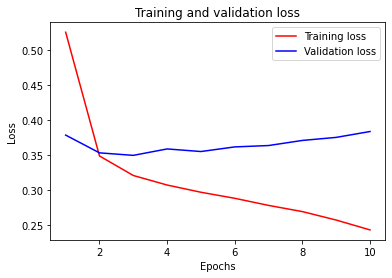

In [30]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# red line
plt.plot(epochs, loss, 'r', label='Training loss')
# blue line
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

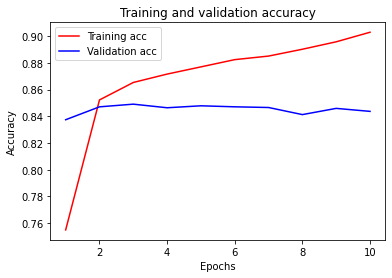

In [31]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Model 2. CNN (Conv1D/GlobalMaxPooling1D) 

Model1과 같은 sequential model을 사용했다. LSTM대신 CNN의 Conv1D/MaxPooling1D레이어를 두번 사용했다. 

* Conv1D: This layer creates a convolution kernel that is convolved with the layer input over a single spatial (or temporal) dimension to produce a tensor of outputs.
    * filters: An interger, the dimensionality of the output space (i.e. the number of output filters in the convolution).
    * kernel size: An integer or tuple/list of a single integer, specifying the length of the 1D convolution window. I tried using a number higher than 7, but it caused an error. I need to investimate why the kernal size is limited to 7. The error message noted that the error is due to a negative dimension size caused by subtracting kernal_size that I set from 7. (error msg: Negative dimension size caused by subtracting 12 from 7 for '{{node sequential_3/conv1d_5/conv1d}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](sequential_3/conv1d_5/conv1d/ExpandDims, sequential_3/conv1d_5/conv1d/ExpandDims_1)' with input shapes: [?,1,7,16], [1,12,16,16].)   
* MaxPooling1D: A type of downsampling for one dimension data. Downsamples the input representation by taking the maximum value over a spatial window of size pool_size. The window is shifted by strides. The resulting output, when using the "valid" padding option, has a shape of: output_shape = (input_shape - pool_size + 1) / strides)
    * pool_size: Integer, size of the max pooling window.
    * strides: Specifies how much the pooling window moves for each pooling step. If None, it will default to pool_size.
* global max pooling 1D: Downsamples the input representation by taking the maximum value over the time dimension.
* Embedding: 
    * Input_shape: 2D tensor with shape: (batch_size, input_length)
    * Output_shape: 3D tensor with shape: (batch_size, input_length, output_dim)


In [32]:
# 모델 만들기 
vocab_size = 10001  
word_vector_dim = 16   

model2 = keras.Sequential()

model2.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model2.add(keras.layers.Conv1D(16, 7, activation='relu'))
model2.add(keras.layers.MaxPooling1D(5))
model2.add(keras.layers.Conv1D(16, 7, activation='relu'))
model2.add(keras.layers.GlobalMaxPooling1D())
model2.add(keras.layers.Dense(8, activation='relu'))
model2.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160016    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

### Model 2 훈련 

* 처음에 epochs를 10로 지정.
* epoch에 따른 accuracy와 loss를 시각화한후, epochs를 8로 바꿔서 다시 돌려주었다. 

In [33]:
model2.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
epochs2=8
history2 = model2.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs2,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/8
173/173 [==============================] - 8s 28ms/step - loss: 0.6644 - accuracy: 0.5799 - val_loss: 0.4286 - val_accuracy: 0.8020
Epoch 2/8
173/173 [==============================] - 2s 10ms/step - loss: 0.3944 - accuracy: 0.8238 - val_loss: 0.3963 - val_accuracy: 0.8156
Epoch 3/8
173/173 [==============================] - 2s 10ms/step - loss: 0.3472 - accuracy: 0.8468 - val_loss: 0.3937 - val_accuracy: 0.8168
Epoch 4/8
173/173 [==============================] - 2s 10ms/step - loss: 0.3214 - accuracy: 0.8626 - val_loss: 0.3971 - val_accuracy: 0.8178
Epoch 5/8
173/173 [==============================] - 2s 10ms/step - loss: 0.2980 - accuracy: 0.8733 - val_loss: 0.4080 - val_accuracy: 0.8181
Epoch 6/8
173/173 [==============================] - 2s 10ms/step - loss: 0.2654 - accuracy: 0.8905 - val_loss: 0.4213 - val_accuracy: 0.8170
Epoch 7/8
173/173 [==============================] - 2s 10ms/step - loss: 0.2351 - accuracy: 0.9057 - val_loss: 0.4441 - val_accuracy: 0.8134
Epoch 

### Model2 평가 

* loss: 0.49
* accuracy: 0.81

In [34]:
model2_result = model2.evaluate(X_test, y_test, verbose=2)
print(model2_result)

1537/1537 - 4s - loss: 0.4891 - accuracy: 0.8048
[0.48907026648521423, 0.8047887086868286]


In [35]:
history_dict2 = history2.history
print(history_dict2.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


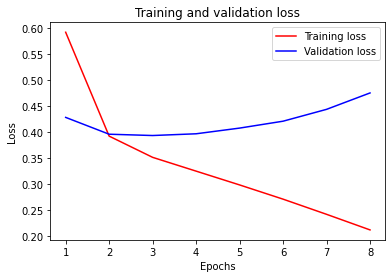

In [36]:
plt.clf() 

acc2 = history_dict2['accuracy']
val_acc2 = history_dict2['val_accuracy']
loss2 = history_dict2['loss']
val_loss2 = history_dict2['val_loss']

epochs = range(1, len(acc2) + 1)

# red line
plt.plot(epochs, loss2, 'r', label='Training loss')
# blue line
plt.plot(epochs, val_loss2, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

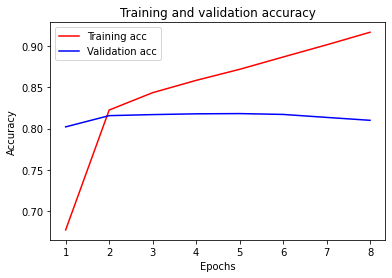

In [37]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc2, 'r', label='Training acc')
plt.plot(epochs, val_acc2, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Model 3 (CNN/LSTM)
* Model 1, 2와 같이 sequential 방법으로 CNN, LSTM을 쌓아주었다. 
* 훈련결과 training accuracy/loss 는 잘 나왔는데 validation 은 값이 epoch 가 지남에 있어서 변화가 미비하고 초기 loss 값이 너무 높았다. regularization 을 해 줄수 있는 방법을 고민하다 dropout layer를 추가해줬다. 

In [38]:
vocab_size = 10001  
word_vector_dim = 16   

model3 = keras.Sequential()

model3.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model3.add(keras.layers.Conv1D(16, 7, activation='relu'))
model3.add(keras.layers.MaxPooling1D(2))
model3.add(keras.layers.LSTM(16))   
model3.add(keras.layers.Dense(8, activation='relu'))
model3.add(keras.layers.Dropout(0.5))
model3.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160016    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

### Model 3 훈련
* epoch를 처음에 10으로 잡았는데, validation loss/accuracy의 성능이 epoch 5를 지나면서 떨어지는 양상을 보였다. 
* 그래서 epoch 를 5로 변경해주었다. 

In [39]:
model3.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
epochs3=5
history3 = model3.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs3,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/5
173/173 [==============================] - 5s 17ms/step - loss: 0.6547 - accuracy: 0.5964 - val_loss: 0.4467 - val_accuracy: 0.8267
Epoch 2/5
173/173 [==============================] - 2s 14ms/step - loss: 0.4718 - accuracy: 0.7983 - val_loss: 0.3916 - val_accuracy: 0.8434
Epoch 3/5
173/173 [==============================] - 2s 14ms/step - loss: 0.4311 - accuracy: 0.8188 - val_loss: 0.3739 - val_accuracy: 0.8435
Epoch 4/5
173/173 [==============================] - 2s 14ms/step - loss: 0.3950 - accuracy: 0.8532 - val_loss: 0.3679 - val_accuracy: 0.8443
Epoch 5/5
173/173 [==============================] - 2s 14ms/step - loss: 0.3647 - accuracy: 0.8721 - val_loss: 0.3751 - val_accuracy: 0.8483


### Model 3 평가
* loss: 0.38
* accuracy: 0.84

In [40]:
model3_result = model3.evaluate(X_test, y_test, verbose=2)
print(model3_result)

1537/1537 - 4s - loss: 0.3828 - accuracy: 0.8445
[0.3827992379665375, 0.8445389270782471]


In [41]:
history_dict3 = history3.history
print(history_dict3.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


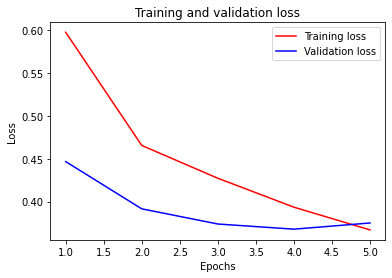

In [42]:
plt.clf() 

acc3 = history_dict3['accuracy']
val_acc3 = history_dict3['val_accuracy']
loss3 = history_dict3['loss']
val_loss3 = history_dict3['val_loss']

epochs = range(1, len(acc3) + 1)

# red line
plt.plot(epochs, loss3, 'r', label='Training loss')
# blue line
plt.plot(epochs, val_loss3, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

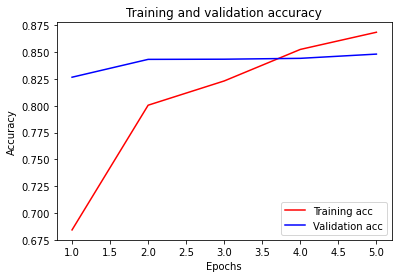

In [43]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc3, 'r', label='Training acc')
plt.plot(epochs, val_acc3, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Step 8. 한국어 Word2Vec 임베딩 활용하여 성능개선

사전 학습된 Word2Vec을 embedding할 때 사용해서 모델의 성능을 개선하려고 한다. 사전 학습된 한국어 Word2Vec은 아래의 링크에서 가져왔다. 
[한국어 Word2Vec은 다음 경로에서 가져왔습니다.](https://github.com/Kyubyong/wordvectors)     

한국어 Word2Vec 임베딩을 모델 1,2,3에 다시 넣어주고 test 데이터를 활용하여 성능을 평가해봤다. 성능의 변화는 다음과 같았다. 성능 향상이 미비한것을 볼 수 있다. 

metrics|model1(LSTM)| model1(LSTM) with Word2Vec| model2(CNN)| model2(CNN) with word2Vec| model3(CNN/LSTM)| model3(CNN/LSTM) with word2Vec
---|---|---|---|---|---|---
loss|0.4| 0.37|0.49|0.47|0.38|0.39
accuracy|0.84|0.84|0.81|0.80|0.84|0.85



In [44]:
import gensim
print(gensim.__version__)

3.8.1


In [45]:
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'
ko_model = gensim.models.Word2Vec.load(word2vec_path)

In [70]:
ko_model['바람'].shape

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


(200,)

In [49]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in ko_model:
        embedding_matrix[i] = ko_model[index_to_word[i]]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


### Model1_w (LSTM) with Word2Vec
Model1과 다른조건은 동일하게 하고, word2vec 사전을 넣어주고, epoch를 7로 조정해서 validation accuracy향상을 위해 노력함. 

In [66]:
vocab_size = 10000    
word_vector_dim = 200  

model1_w = keras.Sequential()

model1_w.add(keras.layers.Embedding(vocab_size, word_vector_dim, embeddings_initializer=Constant(embedding_matrix), 
                                  input_length=maxlen, trainable=True)) # trainable을 True로 주면 Fine-tuning
model1_w.add(keras.layers.LSTM(16))          
model1_w.add(keras.layers.Dense(8, activation='relu'))
model1_w.add(keras.layers.Dense(1, activation='sigmoid'))
         
model1_w.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 48, 200)           2000000   
_________________________________________________________________
lstm_5 (LSTM)                (None, 16)                13888     
_________________________________________________________________
dense_16 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 9         
Total params: 2,014,033
Trainable params: 2,014,033
Non-trainable params: 0
_________________________________________________________________


In [67]:
model1_w.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
epochs1_w=7
history1_w = model1_w.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs1_w,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/7
173/173 [==============================] - 9s 40ms/step - loss: 0.6225 - accuracy: 0.6546 - val_loss: 0.4333 - val_accuracy: 0.8074
Epoch 2/7
173/173 [==============================] - 6s 34ms/step - loss: 0.3936 - accuracy: 0.8321 - val_loss: 0.3925 - val_accuracy: 0.8297
Epoch 3/7
173/173 [==============================] - 6s 33ms/step - loss: 0.3341 - accuracy: 0.8610 - val_loss: 0.3576 - val_accuracy: 0.8443
Epoch 4/7
173/173 [==============================] - 6s 34ms/step - loss: 0.2972 - accuracy: 0.8788 - val_loss: 0.3520 - val_accuracy: 0.8504
Epoch 5/7
173/173 [==============================] - 6s 33ms/step - loss: 0.2761 - accuracy: 0.8885 - val_loss: 0.3554 - val_accuracy: 0.8484
Epoch 6/7
173/173 [==============================] - 6s 33ms/step - loss: 0.2587 - accuracy: 0.8973 - val_loss: 0.3587 - val_accuracy: 0.8519
Epoch 7/7
173/173 [==============================] - 6s 33ms/step - loss: 0.2414 - accuracy: 0.9052 - val_loss: 0.3664 - val_accuracy: 0.8477


In [68]:
model1_w_result = model1_w.evaluate(X_test, y_test, verbose=2)

1537/1537 - 6s - loss: 0.3767 - accuracy: 0.8433


### Model2_w (CNN) with Word2Vec
다른조건은 Model2와 동일하게 하고, word2vec 사전을 넣어주고, epoch를 5로 조정해서 validation accuracy향상을 위해 노력함. 

In [72]:
vocab_size = 10000  
word_vector_dim = 200   

model2_w = keras.Sequential()

model2_w.add(keras.layers.Embedding(vocab_size, word_vector_dim, embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen, trainable=True))
model2_w.add(keras.layers.Conv1D(16, 7, activation='relu'))
model2_w.add(keras.layers.MaxPooling1D(5))
model2_w.add(keras.layers.Conv1D(16, 7, activation='relu'))
model2_w.add(keras.layers.GlobalMaxPooling1D())
model2_w.add(keras.layers.Dense(8, activation='relu'))
model2_w.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model2_w.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 48, 200)           2000000   
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 42, 16)            22416     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 8, 16)             0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 2, 16)             1808      
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 16)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_19 (Dense)             (None, 1)               

In [73]:
model2_w.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
epochs2_w=5
history2_w = model2_w.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs2_w,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/5
173/173 [==============================] - 7s 37ms/step - loss: 0.6636 - accuracy: 0.5815 - val_loss: 0.5406 - val_accuracy: 0.7204
Epoch 2/5
173/173 [==============================] - 6s 33ms/step - loss: 0.4925 - accuracy: 0.7609 - val_loss: 0.4545 - val_accuracy: 0.7855
Epoch 3/5
173/173 [==============================] - 6s 32ms/step - loss: 0.4073 - accuracy: 0.8139 - val_loss: 0.4318 - val_accuracy: 0.7975
Epoch 4/5
173/173 [==============================] - 6s 32ms/step - loss: 0.3589 - accuracy: 0.8405 - val_loss: 0.4156 - val_accuracy: 0.8079
Epoch 5/5
173/173 [==============================] - 6s 33ms/step - loss: 0.3218 - accuracy: 0.8591 - val_loss: 0.4190 - val_accuracy: 0.8107


In [57]:
model2_w_result = model2_w.evaluate(X_test, y_test, verbose=2)

1537/1537 - 4s - loss: 0.4724 - accuracy: 0.8029


### Model3_w (CNN/LSTM) with Word2Vec
다른조건은 model3와 동일하게 하고, word2vec 사전을 넣어주고, epoch를 8로 조정해서 validation accuracy향상을 위해 노력함. 

In [79]:
vocab_size = 10000  
word_vector_dim = 200   

model3_w = keras.Sequential()

model3_w.add(keras.layers.Embedding(vocab_size, word_vector_dim, embeddings_initializer=Constant(embedding_matrix),
                                   input_length=maxlen, trainable=True))
model3_w.add(keras.layers.Conv1D(16, 7, activation='relu'))
model3_w.add(keras.layers.MaxPooling1D(2))
model3_w.add(keras.layers.LSTM(16))   
model3_w.add(keras.layers.Dense(8, activation='relu'))
model3_w.add(keras.layers.Dropout(0.5))
model3_w.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model3_w.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 48, 200)           2000000   
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 42, 16)            22416     
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 21, 16)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dense_22 (Dense)             (None, 8)                 136       
_________________________________________________________________
dropout_3 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_23 (Dense)             (None, 1)               

In [80]:
model3_w.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
epochs3_w=8
history3_w = model3_w.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs3_w,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/8
173/173 [==============================] - 9s 44ms/step - loss: 0.6670 - accuracy: 0.5599 - val_loss: 0.4971 - val_accuracy: 0.7709
Epoch 2/8
173/173 [==============================] - 6s 36ms/step - loss: 0.4982 - accuracy: 0.7788 - val_loss: 0.4044 - val_accuracy: 0.8242
Epoch 3/8
173/173 [==============================] - 6s 36ms/step - loss: 0.4174 - accuracy: 0.8339 - val_loss: 0.3868 - val_accuracy: 0.8314
Epoch 4/8
173/173 [==============================] - 6s 35ms/step - loss: 0.3852 - accuracy: 0.8489 - val_loss: 0.3590 - val_accuracy: 0.8445
Epoch 5/8
173/173 [==============================] - 6s 35ms/step - loss: 0.3494 - accuracy: 0.8680 - val_loss: 0.3578 - val_accuracy: 0.8464
Epoch 6/8
173/173 [==============================] - 6s 35ms/step - loss: 0.3308 - accuracy: 0.8783 - val_loss: 0.3544 - val_accuracy: 0.8469
Epoch 7/8
173/173 [==============================] - 6s 35ms/step - loss: 0.3090 - accuracy: 0.8875 - val_loss: 0.3741 - val_accuracy: 0.8458
Epoch 

In [81]:
model3_w_result = model3_w.evaluate(X_test, y_test, verbose=2)

1537/1537 - 4s - loss: 0.3904 - accuracy: 0.8467
